In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.efficientnet import EfficientNet, EfficientNet_V2_M_Weights
from torchvision.io import read_image

In [2]:
data_path = "/kaggle/input/food-image-classification-dataset/Food Classification dataset"
SEED = 25
img_size = 256
random_degree=90
CLASS_SIZE = 8
BATCH_SIZE = 64
KERNEL_SIZE = 4
STRIDE = 2
PADDING = 1
IS_SHUFFLE = True
NUM_EPOCH = 10
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# Part 1: Modeling and Training a CNN classifier from Scratch

In this part, you are expected to model a CNN classifier and train it. You should first define the components of your model. For instance; a simple architecture might contain 3 convolutional layers and 2 fully connected layers. Define your initial network.

- How many layers are there on your initial classifier? What structure do these layers have? Give details of your parameters; number of in channels, out channels, stride, etc. Specify your architecture in detail. Write about your choice of activation function, loss function and optimization algorithm.
- Show your model’s behaviour with respect to two different learning rates by plotting the change in the loss value wrt epochs.
- After selecting best hyperparameters, give training, validation, and test accuracy. Plot your model’s loss and accuracy change. Comment on your findings.
- Add a regularization method (other than data augmentation) to your training and comment on your findings.

After optimizing the architecture, evaluate it on the test set. What is your model’s test set accuracy? Which classes tend to confuse the most? Explain your findings and results

In [3]:
class FoodDataset(Dataset):
    """A Dataset for food-image-classification-dataset."""
    def __init__(self, root_dir: str, transforms=None):
        """Dataset initialization function."""
        self.root_dir = root_dir
        self.transforms = transforms
        
        self.classes = [folder.name for folder in os.scandir(self.root_dir) if folder.is_dir()][:CLASS_SIZE]
        self.class_index = {cls_: i for i, cls_ in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        ignored_label_list = []
        for class_dir in os.listdir(root_dir)[:CLASS_SIZE]:
            if os.path.isdir(os.path.join(root_dir, class_dir)):
                for filename in os.listdir(os.path.join(root_dir, class_dir)):
                    if self.class_index[class_dir] not in ignored_label_list:
                        image_path = os.path.join(root_dir, class_dir, filename)
                        self.image_paths.append(image_path)
                        self.labels.append(self.class_index[class_dir])
                        
                        if self.labels.count(self.class_index[class_dir]) > 200:
                            ignored_label_list.append(self.class_index[class_dir])

    
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, index) -> [torch.Tensor, int]:
        """Get the image, label for given index."""
        img_path = self.image_paths[index]
        label = self.labels[index]
        
        # img = read_image(img_path)
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label

For each class, you will also select 200 images at random, so your whole dataset size will be ≈ 1600 images. For the **training, validation and test** splits, divide the selected subset by **70% − 10% − 20% ratios**, respectively.

In [4]:
img_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Grayscale(),
    transforms.Resize(size=(img_size, img_size)),
    # transforms.RandomRotation(degrees=random_degree),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
food_dataset = FoodDataset(root_dir=data_path, transforms=img_transforms)
train, val, test = torch.utils.data.random_split(food_dataset,[0.7, 0.1, 0.2])

In [6]:
train.__len__(), val.__len__(), test.__len__()

(1126, 161, 321)

## Part 1.1

**Question**: How many layers are there on your initial classifier? What structure do these layers have? Give details of your parameters; number of in channels, out channels, stride, etc. Specify your architecture in detail. Write about your choice of activation function, loss function and optimization algorithm.

**Answer**: The model created uses 3 convolution layers as well as a max pool layer that processes these convolution outputs, then the convolution outputs are flattened and transferred to 3 linear layers. In this structure, ReLU is used as an activation function. While reducing the image size as input to image_size / 64 at the end of the convolution process, we have 128 filters in the last convolution layer. KERNEL_SIZE = 4, STRIDE = 2, and PADDING = 1 were used in the convolution process.

In [7]:
class FoodClassifier(nn.Module):
    """Custom Food Classfier model."""
    def __init__(self, in_channel: int, class_size: int):
        super(FoodClassifier, self).__init__()
        # 3 Conv, 1 AvgPool, 1 Flatten, 2 Linear
        # NextLayer = ([LayerIn + 2 * Pad - Kernel] / Stride ) + 1
        self.conv_1 = nn.Conv2d(in_channels=in_channel, out_channels=32,
                                kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64,
                                kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128,
                                kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256,
                                kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE)
        self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256,
                                kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE)

        self.avg_pool = nn.AvgPool2d(kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE) # nextOut -> img_size / 2
        self.max_pool = nn.MaxPool2d(kernel_size=KERNEL_SIZE, padding=PADDING, stride=STRIDE) # nextOut -> img_size / 2

        last_img_size = 4
        self.linear1 = nn.Linear(in_features=last_img_size*last_img_size*128, out_features=2**10)
        self.linear2 = nn.Linear(in_features=2**10, out_features=2**6)
        self.linear3 = nn.Linear(in_features=2**6, out_features=class_size)
        
        self.flatten = nn.Flatten()
        # self.dropout = nn.Dropout(p=0.2)

        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = self.relu(self.max_pool(self.conv_1(x)))  # img_size / 4
        x = self.relu(self.max_pool(self.conv_2(x)))  # img_size / 16
        x = self.relu(self.max_pool(self.conv_3(x)))  # img_size / 64
        # x = self.relu(self.conv_4(x))
        # x = self.relu(self.conv_5(x))
        # x = self.avg_pool(x)

        x = self.flatten(x)

        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)

        return x

In [8]:
train_dataloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=IS_SHUFFLE, num_workers=0)
val_dataloader = DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=IS_SHUFFLE, num_workers=0)
test_dataloader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=IS_SHUFFLE, num_workers=0)

In [9]:
model = FoodClassifier(in_channel=train[0][0].shape[0], class_size=len(food_dataset.classes))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [10]:
val_loss_05_list = []
for each_epoch in range(NUM_EPOCH):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = model(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_05_list.append(loss_val)
            val_loss += loss_val

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 2.0793803532918296
Epoch 2 done
Validation loss: 2.0571748415629068
Epoch 3 done
Validation loss: 2.0773185888926187
Epoch 4 done
Validation loss: 2.0794974168141684
Epoch 5 done
Validation loss: 2.080420176188151
Epoch 6 done
Validation loss: 2.0800625483194985
Epoch 7 done
Validation loss: 2.0800134340922036
Epoch 8 done
Validation loss: 2.0804094473520913
Epoch 9 done
Validation loss: 2.080435117085775
Epoch 10 done
Validation loss: 2.0802157719930015


In [12]:
model = FoodClassifier(in_channel=train[0][0].shape[0], class_size=len(food_dataset.classes))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [13]:
val_loss_list_01 = []
for each_epoch in range(NUM_EPOCH):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = model(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

Epoch 1 done
Validation loss: 2.080678621927897
Epoch 2 done
Validation loss: 2.0357566674550376
Epoch 3 done
Validation loss: 1.8570351998011272
Epoch 4 done
Validation loss: 1.9225810766220093
Epoch 5 done
Validation loss: 1.8401665687561035
Epoch 6 done
Validation loss: 1.7366836071014404
Epoch 7 done
Validation loss: 1.6227158308029175
Epoch 8 done
Validation loss: 1.6533076763153076
Epoch 9 done
Validation loss: 1.5623307625452678
Epoch 10 done
Validation loss: 1.966823935508728


## Part 1.2

**Question**: Show your model’s behaviour with respect to two different learning rates by plotting the change in the loss value wrt epochs.

**Answer**: The created model performed better performance under lower learning rate compared than higher learning rate, as shown on plot.


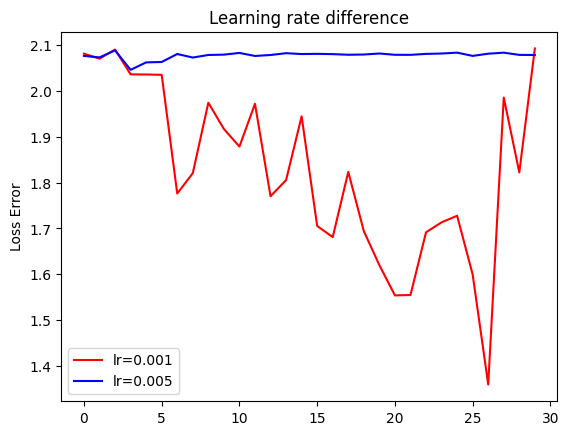

In [14]:
plt.plot(val_loss_list_01, color="red", label="lr=0.001")
plt.plot(val_loss_05_list, color="blue", label="lr=0.005")
plt.title("Learning rate difference")
plt.ylabel("Loss Error")
plt.legend()
plt.show()

## Part 1.3

**Question**: After selecting best hyperparameters, give training, validation, and test accuracy. Plot your model’s loss and accuracy change. Comment on your findings.

**Answer**: It shows that `learning_rate=0.0005` is the best learning rate for created method.

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
model = FoodClassifier(in_channel=train[0][0].shape[0], class_size=len(food_dataset.classes))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [17]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = model(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 2.07812770207723


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 2.070937236150106


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 2.0507379372914634


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 1.9784892002741497


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 1.849731206893921


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 1.746930201848348


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 1.709025780359904


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 1.7477909723917644


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 1.6259447733561199
Epoch 10 done
Validation loss: 1.570927341779073


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


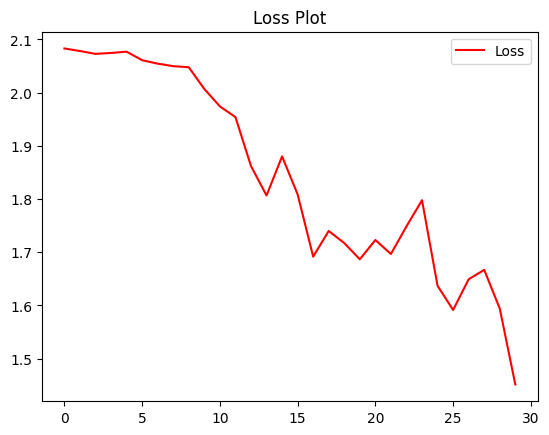

In [18]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Loss Plot")
plt.show()

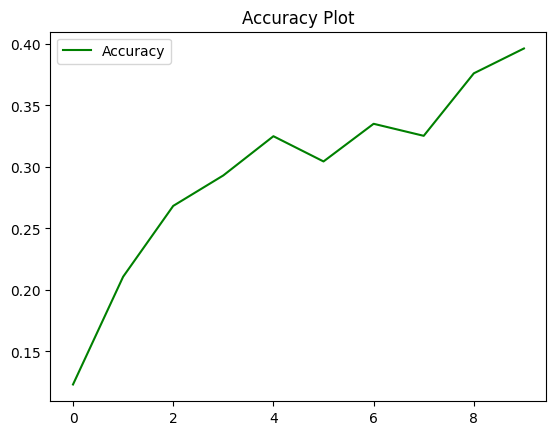

In [19]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.show()

In [20]:
model.eval()

test_loss_list_b = []
total_accuracy = 0
with torch.no_grad():
    test_loss = 0
    for i, (test_img, test_label) in enumerate(test_dataloader):
        test_img = test_img.to(DEVICE)
        test_label = test_label.to(DEVICE)

        test_predicted = model(test_img)
        
        acc_score = accuracy_score(test_label.cpu(), torch.argmax(test_predicted, dim=1).cpu())
        loss = criterion(test_predicted, test_label)
        loss_test = loss.item()

        test_loss_list_b.append(loss_test)
        test_loss += loss_test
        total_accuracy += acc_score

    print("="*50)
    print(f"Epoch {each_epoch+1} done")
    print(f"Test loss: {test_loss/(i+1)}")
    print(f"Test accuracy: {total_accuracy/(i+1)}")
    print("="*50)


Epoch 10 done
Test loss: 1.5554228723049164
Test accuracy: 0.4036458333333333


In [21]:
model = FoodClassifier(in_channel=train[0][0].shape[0], class_size=len(food_dataset.classes))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [22]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = model(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 2.018625815709432


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 1.9252663056055705


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 1.8076777458190918


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 1.8312541246414185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 1.74399729569753


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 1.618950883547465


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 1.6063941717147827


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 1.5531240701675415


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 1.515001932779948


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 1.429312785466512


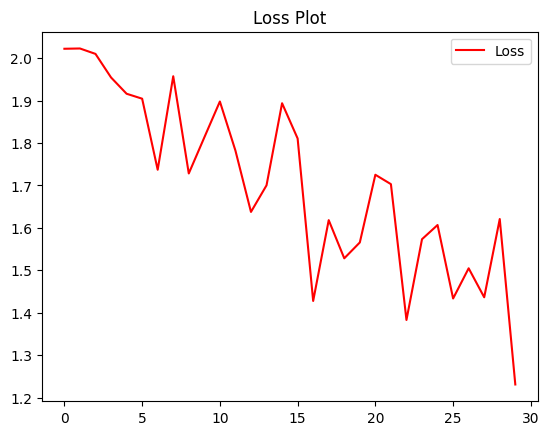

In [23]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Loss Plot")
plt.show()

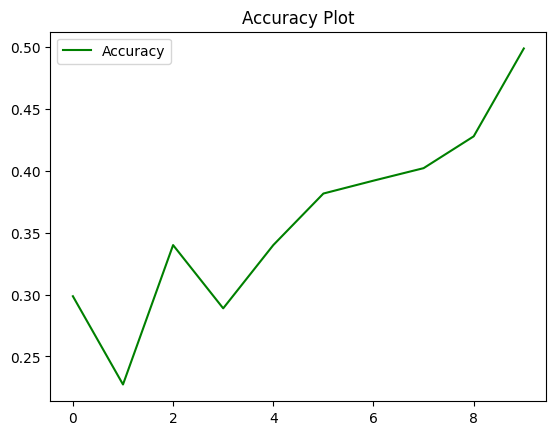

In [24]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.show()

In [25]:
model.eval()

test_loss_list_b = []
total_accuracy = 0
with torch.no_grad():
    test_loss = 0
    for i, (test_img, test_label) in enumerate(test_dataloader):
        test_img = test_img.to(DEVICE)
        test_label = test_label.to(DEVICE)

        test_predicted = model(test_img)
        
        acc_score = accuracy_score(test_label.cpu(), torch.argmax(test_predicted, dim=1).cpu())
        loss = criterion(test_predicted, test_label)
        loss_test = loss.item()

        test_loss_list_b.append(loss_test)
        test_loss += loss_test
        total_accuracy += acc_score

    print("="*50)
    print(f"Epoch {each_epoch+1} done")
    print(f"Test loss: {test_loss/(i+1)}")
    print(f"Test accuracy: {total_accuracy/(i+1)}")
    print("="*50)


Epoch 10 done
Test loss: 1.6814978917439778
Test accuracy: 0.3177083333333333


## Part 1.4

**Question**: Add a regularization method (other than data augmentation) to your training and comment on your findings

**Answer**: Update Adam optimizer as adding weight_decay as `L2 regularization`.

In [26]:
model = FoodClassifier(in_channel=train[0][0].shape[0], class_size=len(food_dataset.classes))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005, amsgrad=True, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [27]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = model(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

    # Validation loss
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = model(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 2.0788381894429526


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 2.009687582651774


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 1.911976973215739


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 1.8134679396947224


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 1.8395739396413167


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 1.6720494429270427


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 1.7334693670272827


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 1.6122968594233196


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 1.5271708170572917


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 1.5352380275726318


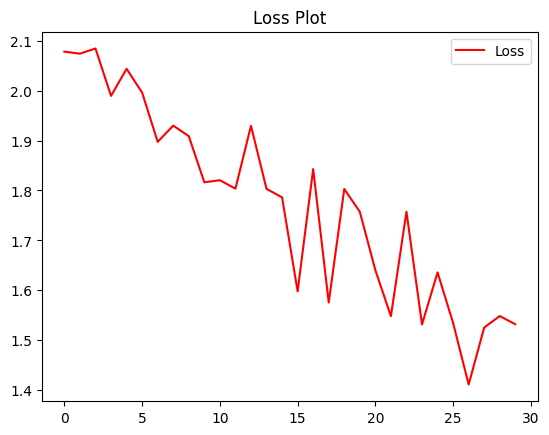

In [28]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Loss Plot")
plt.show()

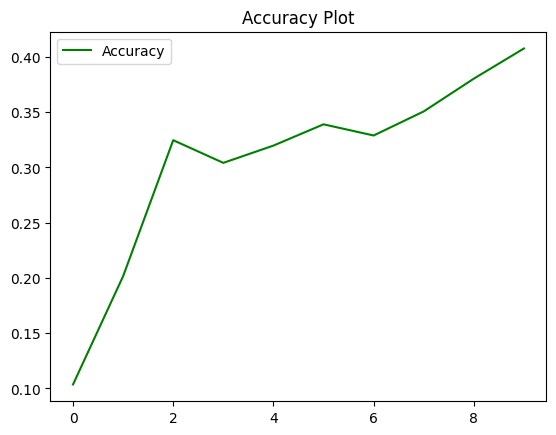

In [29]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.show()

## Part 1.5

**Question**: After optimizing the architecture, evaluate it on the test set. What is your model’s test set accuracy? Which classes tend to confuse the most? Explain your findings and results.

**Answer**: The model did not trained but it shows that fried rice is the best founded class.

In [31]:
model.eval()

y_pred = []
y_true = []
test_loss_list_b = []
total_accuracy = 0
with torch.no_grad():
    test_loss = 0
    for i, (test_img, test_label) in enumerate(test_dataloader):
        test_img = test_img.to(DEVICE)
        test_label = test_label.to(DEVICE)

        test_predicted = model(test_img)
        
        output = (torch.max(torch.exp(test_predicted), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = test_label.data.cpu().numpy()
        y_true.extend(labels)
        
        acc_score = accuracy_score(test_label.cpu(), torch.argmax(test_predicted, dim=1).cpu())
        loss = criterion(test_predicted, test_label)
        loss_test = loss.item()

        test_loss_list_b.append(loss_test)
        test_loss += loss_test
        total_accuracy += acc_score

    print("="*50)
    print(f"Epoch {each_epoch+1} done")
    print(f"Test loss: {test_loss/(i+1)}")
    print(f"Test accuracy: {total_accuracy/(i+1)}")
    print("="*50)


Epoch 10 done
Test loss: 1.7322621544202168
Test accuracy: 0.296875


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [33]:
test.dataset.classes[:CLASS_SIZE]

['momos',
 'dhokla',
 'kaathi_rolls',
 'chole_bhature',
 'masala_dosa',
 'Donut',
 'Sandwich',
 'Hot Dog']

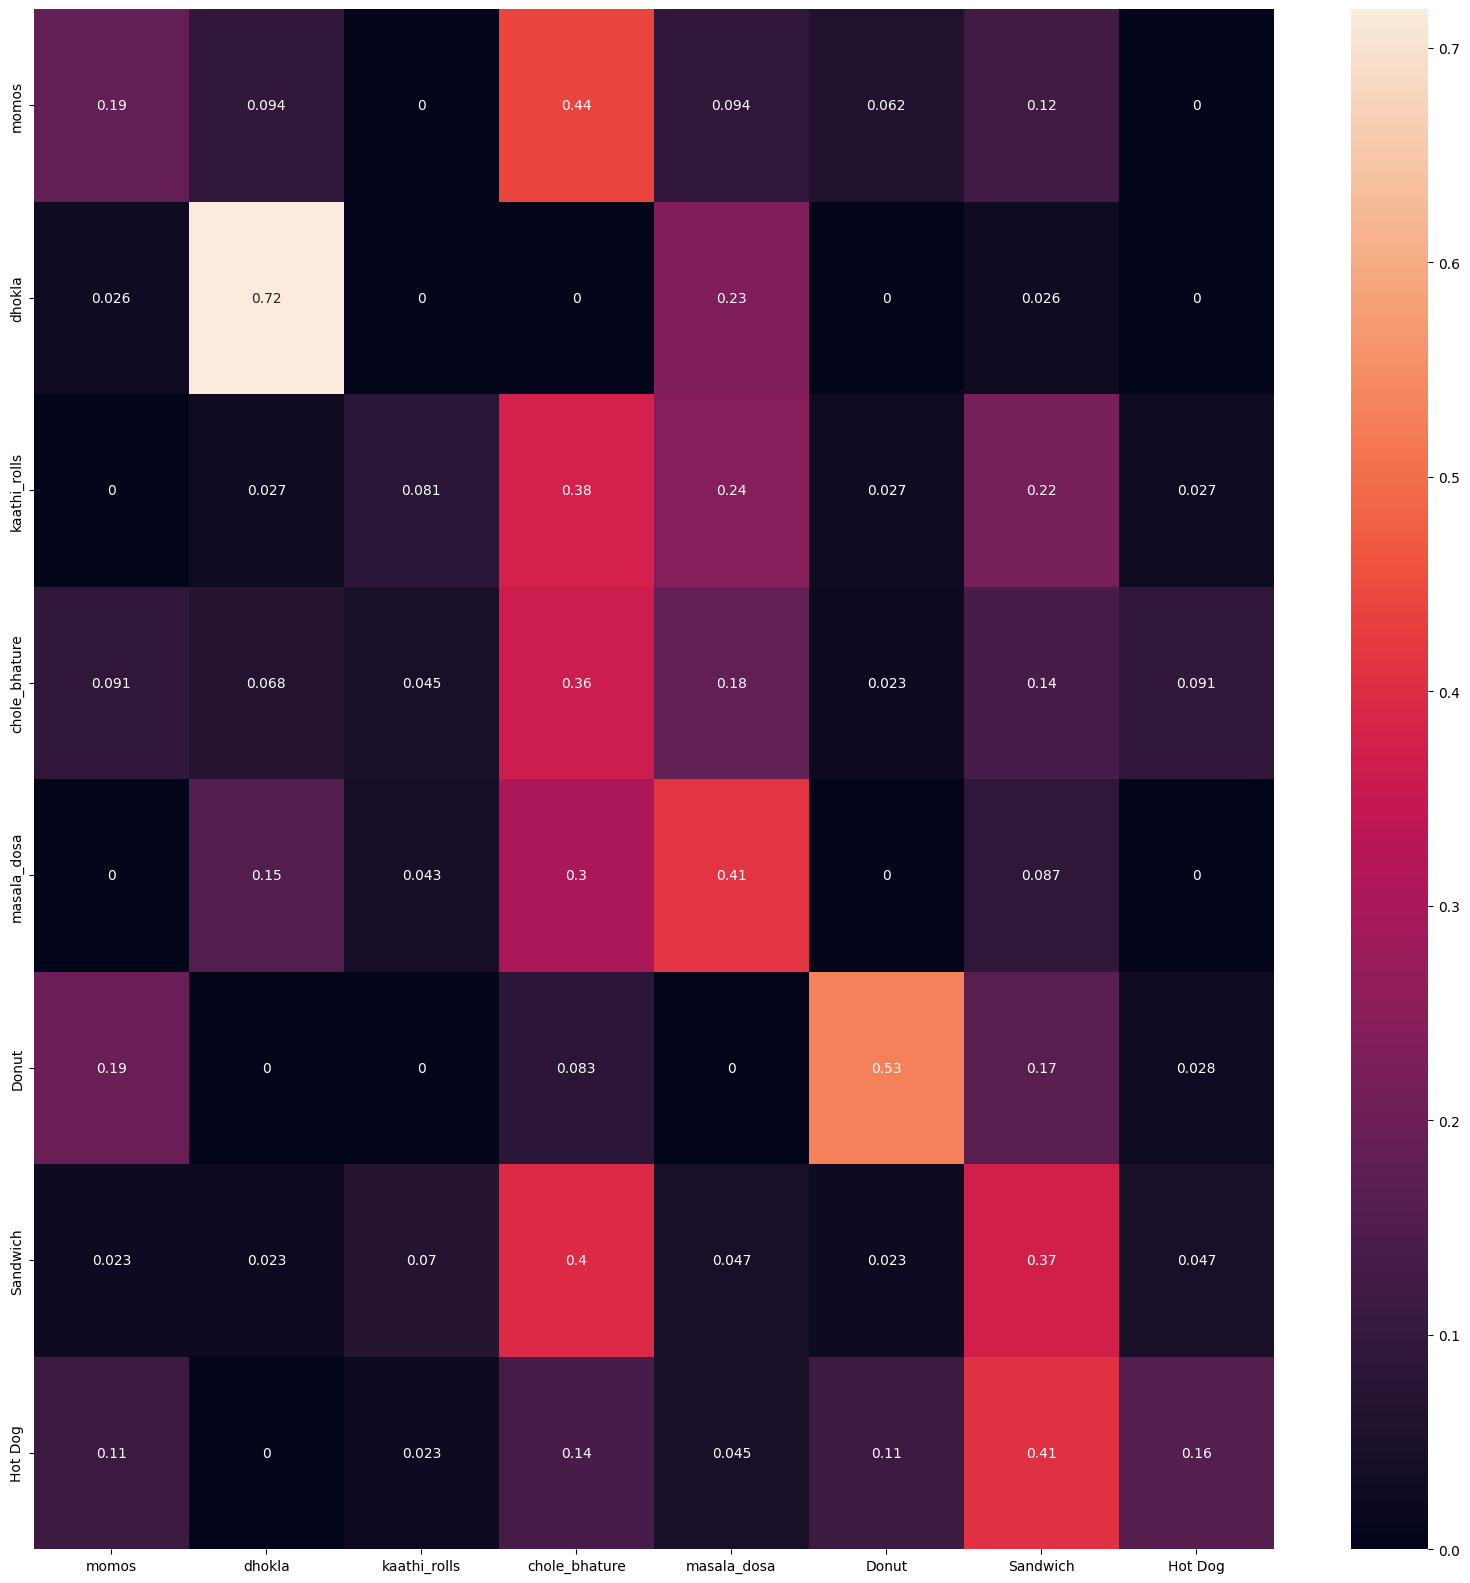

In [34]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in test.dataset.classes[:CLASS_SIZE]],
                     columns = [i for i in test.dataset.classes[:CLASS_SIZE]])
plt.figure(figsize = (20, 20))
sn.heatmap(df_cm, annot=True)
plt.show()

# Part 2: Transfer Learning with CNNs

Now, fine-tune the EfficientNet B0 or EfficientNetV2 B0 network pre-trained on ImageNet (Download the pretrained model from internet. The Pytorch version of EfficientNet is available [here](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html)). Freeze all the layers, except the FC layer and train FC layer for this food classification problem.

- Explore finetuning different number of layers. Tune your parameters accordingly and give accuracy on validation set. Compare your results.
- Evaluate your best model (the model that gives the best results in the validation set) in the test set. Discuss the results.

Compare the results of Part-1 and Part-2. State your observations clearly and precisely.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.efficientnet import EfficientNet, EfficientNet_V2_M_Weights
from torchvision.io import read_image
from sklearn.metrics import accuracy_score

In [2]:
data_path = "/kaggle/input/food-image-classification-dataset/Food Classification dataset"
SEED = 25
img_size = 224
random_degree=90
BATCH_SIZE = 64
KERNEL_SIZE = 4
CLASS_SIZE = 8
STRIDE = 2
PADDING = 1
IS_SHUFFLE = True
NUM_EPOCH = 10
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
class FoodDataset(Dataset):
    """A Dataset for food-image-classification-dataset."""
    def __init__(self, root_dir: str, transforms=None):
        """Dataset initialization function."""
        self.root_dir = root_dir
        self.transforms = transforms
        
        self.classes = [folder.name for folder in os.scandir(self.root_dir) if folder.is_dir()][:CLASS_SIZE]
        self.class_index = {cls_: i for i, cls_ in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        ignored_label_list = []
        for class_dir in os.listdir(root_dir)[:CLASS_SIZE]:
            if os.path.isdir(os.path.join(root_dir, class_dir)):
                for filename in os.listdir(os.path.join(root_dir, class_dir)):
                    if self.class_index[class_dir] not in ignored_label_list:
                        image_path = os.path.join(root_dir, class_dir, filename)
                        self.image_paths.append(image_path)
                        self.labels.append(self.class_index[class_dir])
                        
                        if self.labels.count(self.class_index[class_dir]) > 200:
                            ignored_label_list.append(self.class_index[class_dir])

    
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, index) -> [torch.Tensor, int]:
        """Get the image, label for given index."""
        img_path = self.image_paths[index]
        label = self.labels[index]
        
        # img = read_image(img_path)
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label

In [4]:
from torchvision.models.efficientnet import efficientnet_v2_s, EfficientNet_V2_S_Weights

In [5]:
img_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Grayscale(),
    transforms.Resize(size=(img_size, img_size)),
    # transforms.RandomRotation(degrees=random_degree),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
food_dataset = FoodDataset(root_dir=data_path, transforms=img_transforms)
train, val, test = torch.utils.data.random_split(food_dataset,[0.7, 0.1, 0.2])

In [7]:
train_dataloader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_dataloader = DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [8]:
efficientnetv2 = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 135MB/s] 


In [9]:
for each in efficientnetv2.parameters():
    each.requires_grad = False

## Part 2.1
**Question**: Explore finetuning different number of layers. Tune your parameters accordingly and give accuracy on validation set. Compare your results.

**Answer**: The basic output (%50 dropout and one linear layer) is performed best performance.

In [44]:
efficientnetv2.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features=1280, out_features=len(food_dataset.classes)))

In [45]:
efficientnetv2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [46]:
efficientnetv2 = efficientnetv2.to(DEVICE)

In [47]:
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [48]:
val_loss_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    efficientnetv2.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_value = loss.item()
            val_loss_list.append(loss_value)
            val_loss += loss_value

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 0.6931115786234537
Epoch 2 done
Validation loss: 0.5061764319737753
Epoch 3 done
Validation loss: 0.4638383785883586
Epoch 4 done
Validation loss: 0.4234351913134257
Epoch 5 done
Validation loss: 0.3976020912329356
Epoch 6 done
Validation loss: 0.39966745177904767
Epoch 7 done
Validation loss: 0.3926067849000295
Epoch 8 done
Validation loss: 0.39763691027959186
Epoch 9 done
Validation loss: 0.38616617520650226
Epoch 10 done
Validation loss: 0.38578446706136066


In [49]:
# Test different layer
efficientnetv2.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features=1280, out_features=512), nn.Linear(in_features=512, out_features=128), nn.Linear(in_features=128, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [50]:
val_loss_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    efficientnetv2.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_value = loss.item()
            val_loss_list.append(loss_value)
            val_loss += loss_value

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

Epoch 1 done
Validation loss: 0.6817334691683451
Epoch 2 done
Validation loss: 0.6547016700108846
Epoch 3 done
Validation loss: 0.6317172050476074
Epoch 4 done
Validation loss: 0.5239859024683634
Epoch 5 done
Validation loss: 0.4229059120019277
Epoch 6 done
Validation loss: 0.40834681193033856
Epoch 7 done
Validation loss: 0.4964678883552551
Epoch 8 done
Validation loss: 0.5555302699406942
Epoch 9 done
Validation loss: 0.5480044285456339
Epoch 10 done
Validation loss: 0.4577079514662425


In [51]:
# Test accuracy 0.0005
efficientnetv2.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features=1280, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.0005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [52]:
val_loss_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    efficientnetv2.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_value = loss.item()
            val_loss_list.append(loss_value)
            val_loss += loss_value

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

Epoch 1 done
Validation loss: 1.8208940029144287
Epoch 2 done
Validation loss: 1.5959928433100383
Epoch 3 done
Validation loss: 1.4159801403681438
Epoch 4 done
Validation loss: 1.271465539932251
Epoch 5 done
Validation loss: 1.1537495056788127
Epoch 6 done
Validation loss: 1.05375075340271
Epoch 7 done
Validation loss: 0.9794267217318217
Epoch 8 done
Validation loss: 0.9129568338394165
Epoch 9 done
Validation loss: 0.8588606516520182
Epoch 10 done
Validation loss: 0.809955875078837


In [53]:
# Test learning rate 0.001
efficientnetv2.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features=1280, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.001, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [54]:
val_loss_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

            
    # Validation loss
    efficientnetv2.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            # val_predicted_labels = torch.argmax(val_predicted, dim=1)
            loss = criterion(val_predicted, val_label)
            loss_value = loss.item()
            val_loss_list.append(loss_value)
            val_loss += loss_value

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

Epoch 1 done
Validation loss: 1.6083614428838093
Epoch 2 done
Validation loss: 1.2635997931162517
Epoch 3 done
Validation loss: 1.0420784552892048
Epoch 4 done
Validation loss: 0.9019777178764343
Epoch 5 done
Validation loss: 0.8010072509447733
Epoch 6 done
Validation loss: 0.7268703579902649
Epoch 7 done
Validation loss: 0.673214852809906
Epoch 8 done
Validation loss: 0.6320057113965353
Epoch 9 done
Validation loss: 0.5969836711883545
Epoch 10 done
Validation loss: 0.5692351659138998


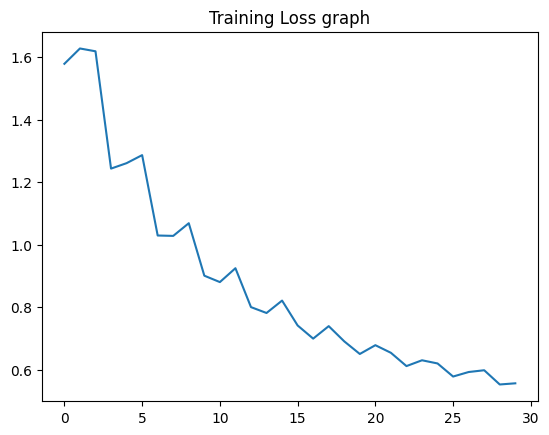

In [55]:
plt.plot(val_loss_list)
plt.title("Training Loss graph")
plt.show()

In [56]:
# Best transferred model
efficientnetv2.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features=1280, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [57]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

    # Validation loss
    efficientnetv2.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 0.7398383816083273


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 0.5253229041894277


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 0.4535155196984609


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 0.4050450026988983


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 0.3959871431191762


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 0.3604131241639455


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 0.3863728145758311


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 0.3455468813578288


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 0.35400023063023883


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 0.3518875539302826


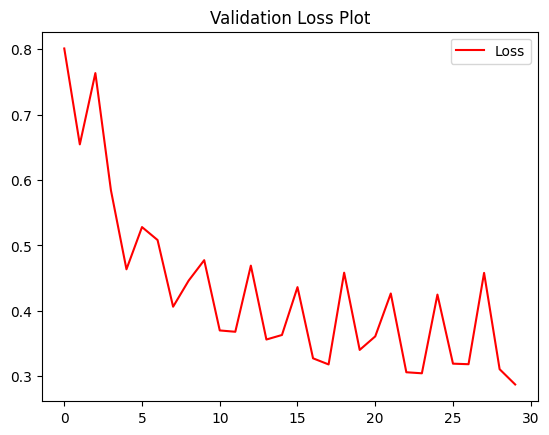

In [58]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Loss Plot")
plt.show()

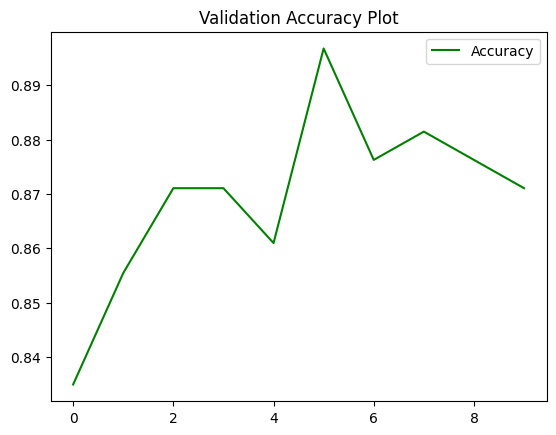

In [59]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Accuracy Plot")
plt.show()

In [60]:
efficientnetv2.eval()

y_pred = []
y_true = []
test_loss_list_b = []
total_accuracy = 0
with torch.no_grad():
    test_loss = 0
    for i, (test_img, test_label) in enumerate(test_dataloader):
        test_img = test_img.to(DEVICE)
        test_label = test_label.to(DEVICE)

        test_predicted = efficientnetv2(test_img)
        
        output = (torch.max(torch.exp(test_predicted), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = test_label.data.cpu().numpy()
        y_true.extend(labels)
        
        acc_score = accuracy_score(test_label.cpu(), torch.argmax(test_predicted, dim=1).cpu())
        loss = criterion(test_predicted, test_label)
        loss_test = loss.item()

        test_loss_list_b.append(loss_test)
        test_loss += loss_test
        total_accuracy += acc_score

    print("="*50)
    print(f"Epoch {each_epoch+1} done")
    print(f"Test loss: {test_loss/(i+1)}")
    print(f"Test accuracy: {total_accuracy/(i+1)}")
    print("="*50)


Epoch 10 done
Test loss: 0.4031158262223471
Test accuracy: 0.859375


In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

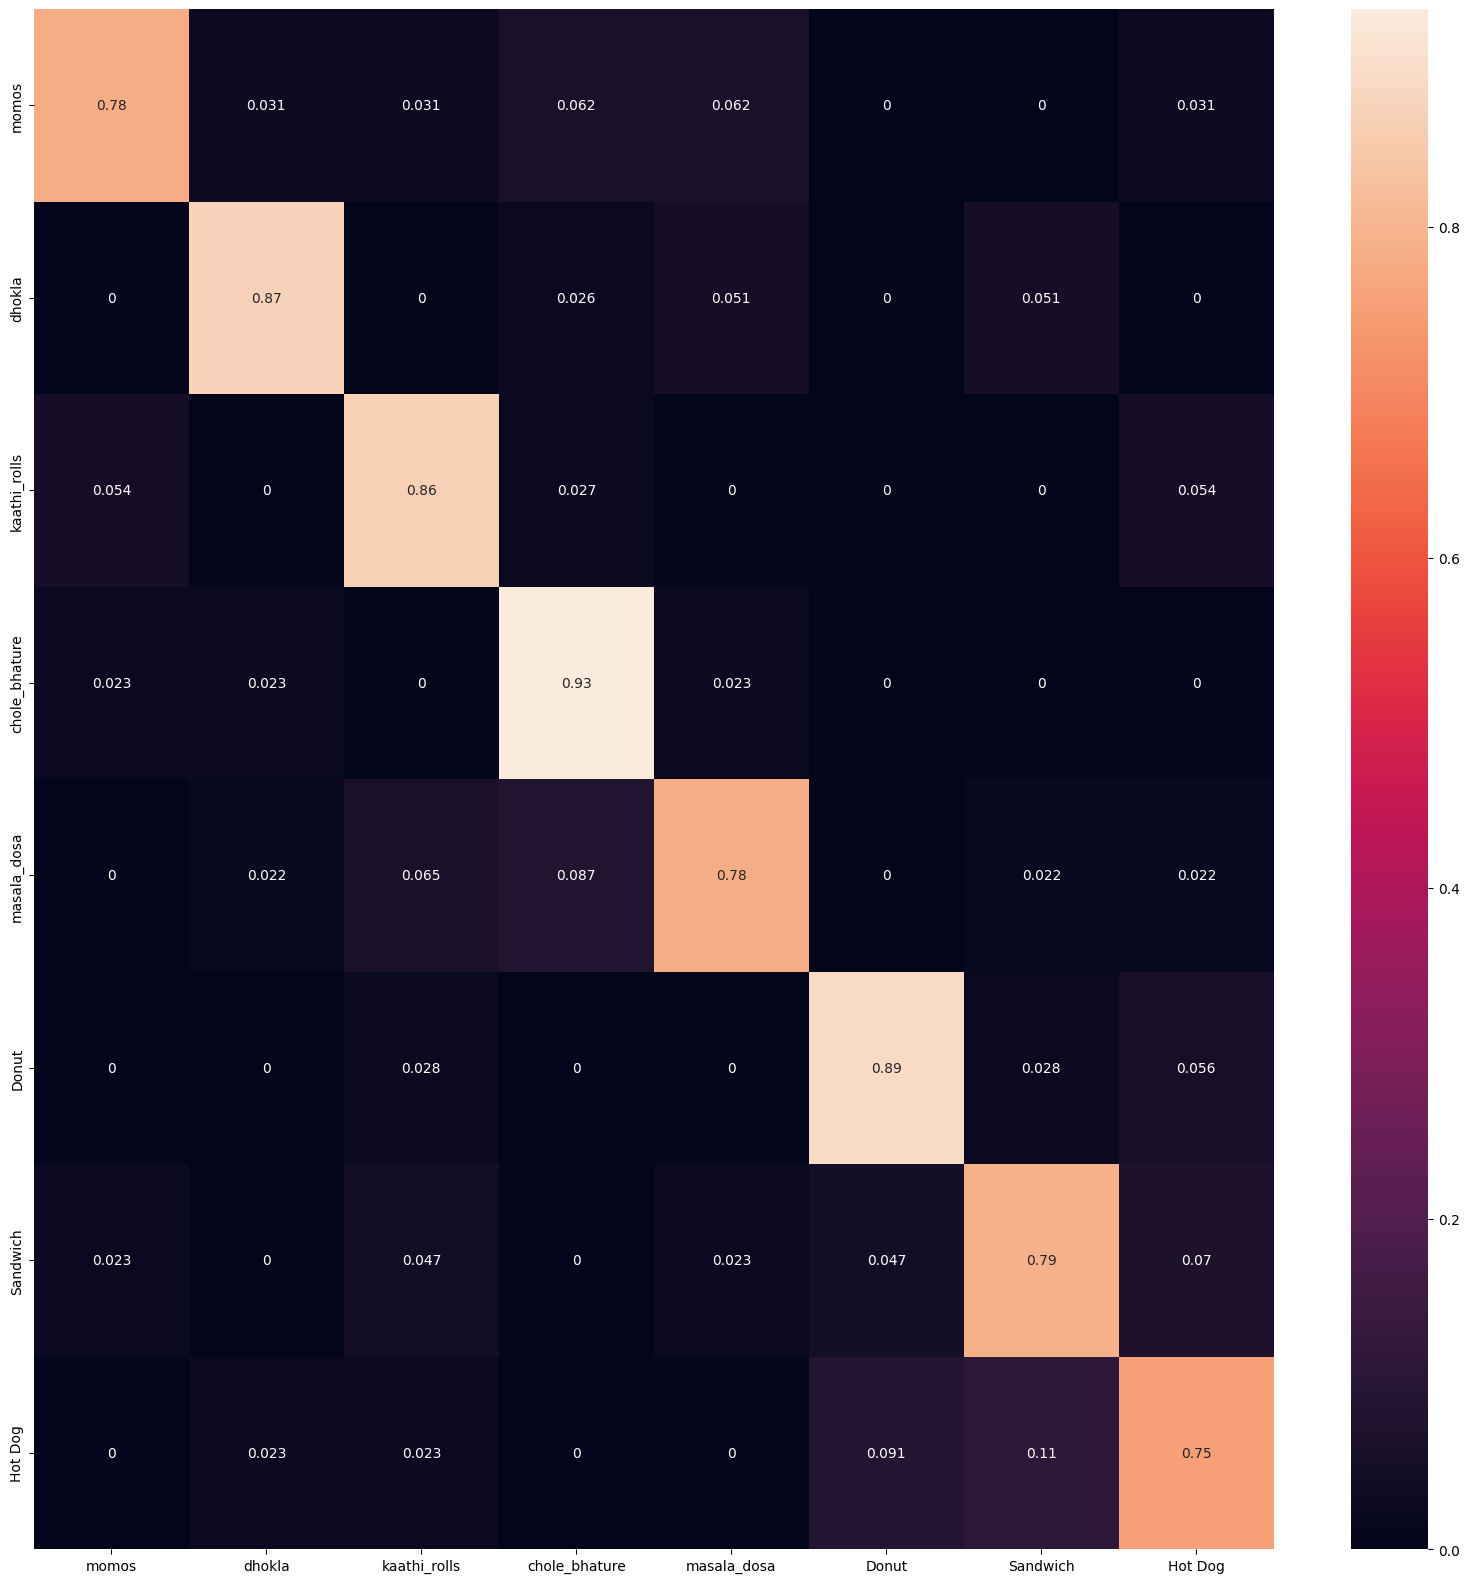

In [62]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in test.dataset.classes[:CLASS_SIZE]],
                     columns = [i for i in test.dataset.classes[:CLASS_SIZE]])
plt.figure(figsize = (20, 20))
sn.heatmap(df_cm, annot=True)
plt.show()

## Task 2.2 Compare the results of Part-1 and Part-2. State your observations clearly and precisely.

**Answer**: EfficientV2 has better performance than created primitive previous model.

# Part 3: CNNs with Soft Attention

Implement the soft-attention mechanism that is discussed in class and using your best model from Part-1 or Part-2 as your base CNN model, incorporate the attention mechanism to your base network.

- Experiment with using this attention layer in different parts of the network.
- Evaluate your best model in the test set. Compare your base CNN with the attention-added version.

Discuss the models from all the parts clearly and extensively. State all your observations.

In [42]:
### Linear Attention
# class SoftAttention(nn.Module):
#     def __init__(self, feature_size):
#         super(SoftAttention, self).__init__()
#         self.feature_size = feature_size
#         self.query = nn.Linear(feature_size, feature_size)
#         self.key = nn.Linear(feature_size, feature_size)
#         self.value = nn.Linear(feature_size, feature_size)
# 
#     def forward(self, x):
#         queries = self.query(x)
#         keys = self.key(x)
#         values = self.value(x)
# 
#         scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))
# 
#         attention_weights = nn.functional.softmax(scores, dim=-1)
# 
#         output = torch.matmul(attention_weights, values)
#         return output, attention_weights

In [29]:
class SelfAttentionConv(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttentionConv, self).__init__()
        self.chanel_in = in_dim
        self.activation = nn.ReLU()
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [36]:
class ConvAttentionBlock(nn.Module):
    """Serkan's custom conv block."""
    def __init__(self, in_features: int, out_features: int, kernel_size: int):
        super(ConvAttentionBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size)
        self.att = SelfAttentionConv(in_dim=out_features)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv(x))
        x = self.att(x)
        
        return x[0]

In [41]:
s_block = ConvAttentionBlock(in_features=128, out_features=1280, kernel_size=1)
s_block(torch.tensor(range(0,128*4*4)).type(torch.float32).view(128,4,4).unsqueeze(0))

tensor([[[[102.2840, 102.6385, 102.9931, 103.3478],
          [103.7022, 104.0569, 104.4117, 104.7662],
          [105.1206, 105.4751, 105.8296, 106.1846],
          [106.5388, 106.8938, 107.2483, 107.6026]],

         [[  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000]],

         ...,

         [[  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000, 

In [53]:
# Test ConvAttentionBlock
efficientnetv2.avgpool = nn.Sequential(ConvAttentionBlock(in_features=1280, out_features=1280, kernel_size=1), nn.AdaptiveAvgPool2d(output_size=1))
efficientnetv2.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [54]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

    # Validation loss
    efficientnetv2.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 0.7665163278579712


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 0.5617645680904388


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 0.38117871681849164


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 0.3696521023909251


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 0.3805043449004491


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 0.4335612306992213


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 0.4499630431334178


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 0.3596627513567607


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 0.4213045537471771


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 0.3890122671922048


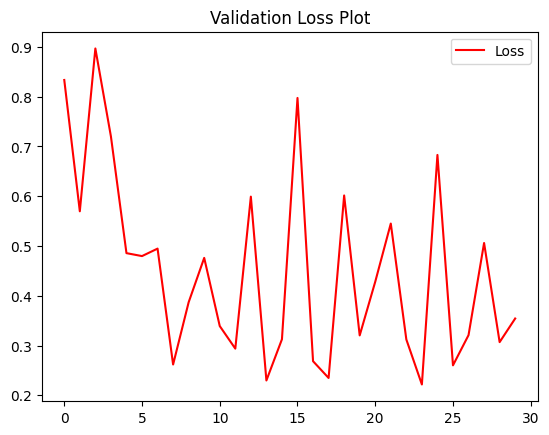

In [55]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Loss Plot")
plt.show()

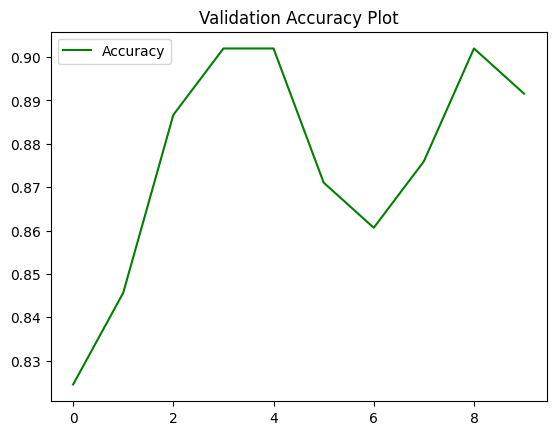

In [56]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Accuracy Plot")
plt.show()

In [58]:
# Test multiple ConvAttentionBlock performance
efficientnetv2.avgpool = nn.Sequential(ConvAttentionBlock(in_features=1280, out_features=512, kernel_size=1),
                                       ConvAttentionBlock(in_features=512, out_features=128, kernel_size=1),
                                       ConvAttentionBlock(in_features=128, out_features=32, kernel_size=1),
                                       nn.AdaptiveAvgPool2d(output_size=1))
efficientnetv2.classifier = nn.Sequential(nn.Linear(in_features=32, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [59]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

    # Validation loss
    efficientnetv2.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 1.3853394587834675


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 0.8106049497922262


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 0.5750661293665568


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 0.5287931164105734


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 0.49275218447049457


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 0.45988692839940387


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 0.47631434599558514


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 0.5147364834944407


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 0.5101426541805267


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 0.4783414800961812


In [60]:
# Test ConvAttentionBlock performance v2
efficientnetv2.avgpool = nn.Sequential(ConvAttentionBlock(in_features=1280, out_features=32, kernel_size=1),
                                       nn.AdaptiveAvgPool2d(output_size=1))
efficientnetv2.classifier = nn.Sequential(nn.Linear(in_features=32, out_features=len(food_dataset.classes)))
efficientnetv2 = efficientnetv2.to(DEVICE)
optimizer = torch.optim.Adam(params=efficientnetv2.parameters(), lr=0.005, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [61]:
val_loss_list_01 = []
acc_list = []
for each_epoch in range(NUM_EPOCH):
    efficientnetv2.train()
    for index, (img, label) in enumerate(train_dataloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        pred = efficientnetv2(img)
        # pred_labels = torch.argmax(predicted, dim=1)
        loss = criterion(pred, label)
        loss.backward()
        
        optimizer.step()

    # Validation loss
    efficientnetv2.eval()
    total_accuracy = 0
    with torch.no_grad():
        val_loss = 0
        for i, (val_img, val_label) in enumerate(val_dataloader):
            val_img = val_img.to(DEVICE)
            val_label = val_label.to(DEVICE)

            val_predicted = efficientnetv2(val_img)
            acc_score = accuracy_score(val_label.cpu(), torch.argmax(val_predicted, dim=1).cpu())

            loss = criterion(val_predicted, val_label)
            loss_val = loss.item()
            val_loss_list_01.append(loss_val)
            val_loss += loss_val
            total_accuracy += acc_score
        acc_list.append(total_accuracy/(i+1))

        print("="*50)
        print(f"Epoch {each_epoch+1} done")
        print(f"Validation loss: {val_loss/(i+1)}")
        print("="*50)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 done
Validation loss: 0.8130766948064169


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2 done
Validation loss: 0.4579448203245799


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 done
Validation loss: 0.40413224697113037


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4 done
Validation loss: 0.3480013112227122


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 done
Validation loss: 0.45452460646629333


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6 done
Validation loss: 0.4248640338579814


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7 done
Validation loss: 0.3925172984600067


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8 done
Validation loss: 0.4105779230594635


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9 done
Validation loss: 0.38245803614457446


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10 done
Validation loss: 0.35919874906539917


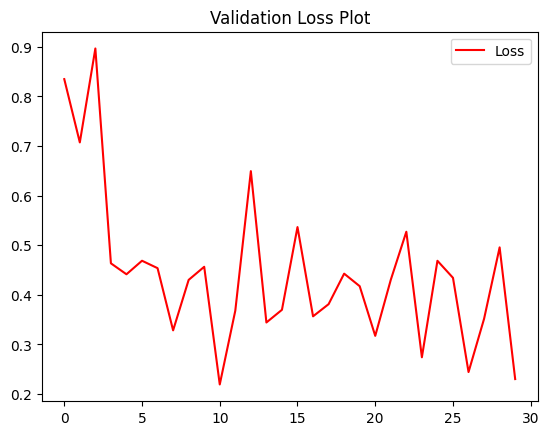

In [62]:
plt.plot(val_loss_list_01, color="red", label="Loss")
# plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Loss Plot")
plt.show()

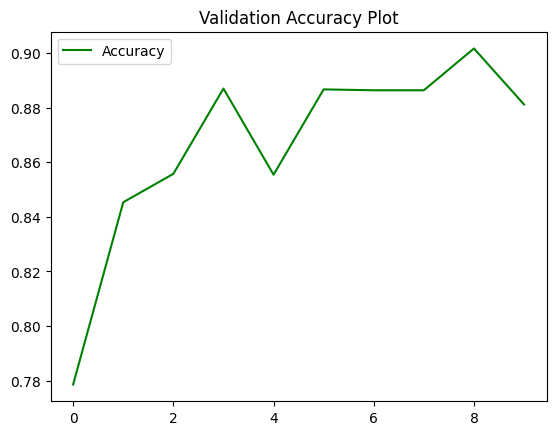

In [63]:
# plt.plot(val_loss_list_01, color="red", label="Loss")
plt.plot(acc_list, color="green", label="Accuracy")
plt.legend()
plt.title("Validation Accuracy Plot")
plt.show()

In [64]:
efficientnetv2.eval()

y_pred = []
y_true = []
test_loss_list_b = []
total_accuracy = 0
with torch.no_grad():
    test_loss = 0
    for i, (test_img, test_label) in enumerate(test_dataloader):
        test_img = test_img.to(DEVICE)
        test_label = test_label.to(DEVICE)

        test_predicted = efficientnetv2(test_img)
        
        output = (torch.max(torch.exp(test_predicted), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = test_label.data.cpu().numpy()
        y_true.extend(labels)
        
        acc_score = accuracy_score(test_label.cpu(), torch.argmax(test_predicted, dim=1).cpu())
        loss = criterion(test_predicted, test_label)
        loss_test = loss.item()

        test_loss_list_b.append(loss_test)
        test_loss += loss_test
        total_accuracy += acc_score

    print("="*50)
    print(f"Epoch {each_epoch+1} done")
    print(f"Test loss: {test_loss/(i+1)}")
    print(f"Test accuracy: {total_accuracy/(i+1)}")
    print("="*50)


Epoch 10 done
Test loss: 0.4387802779665814
Test accuracy: 0.8828125


In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

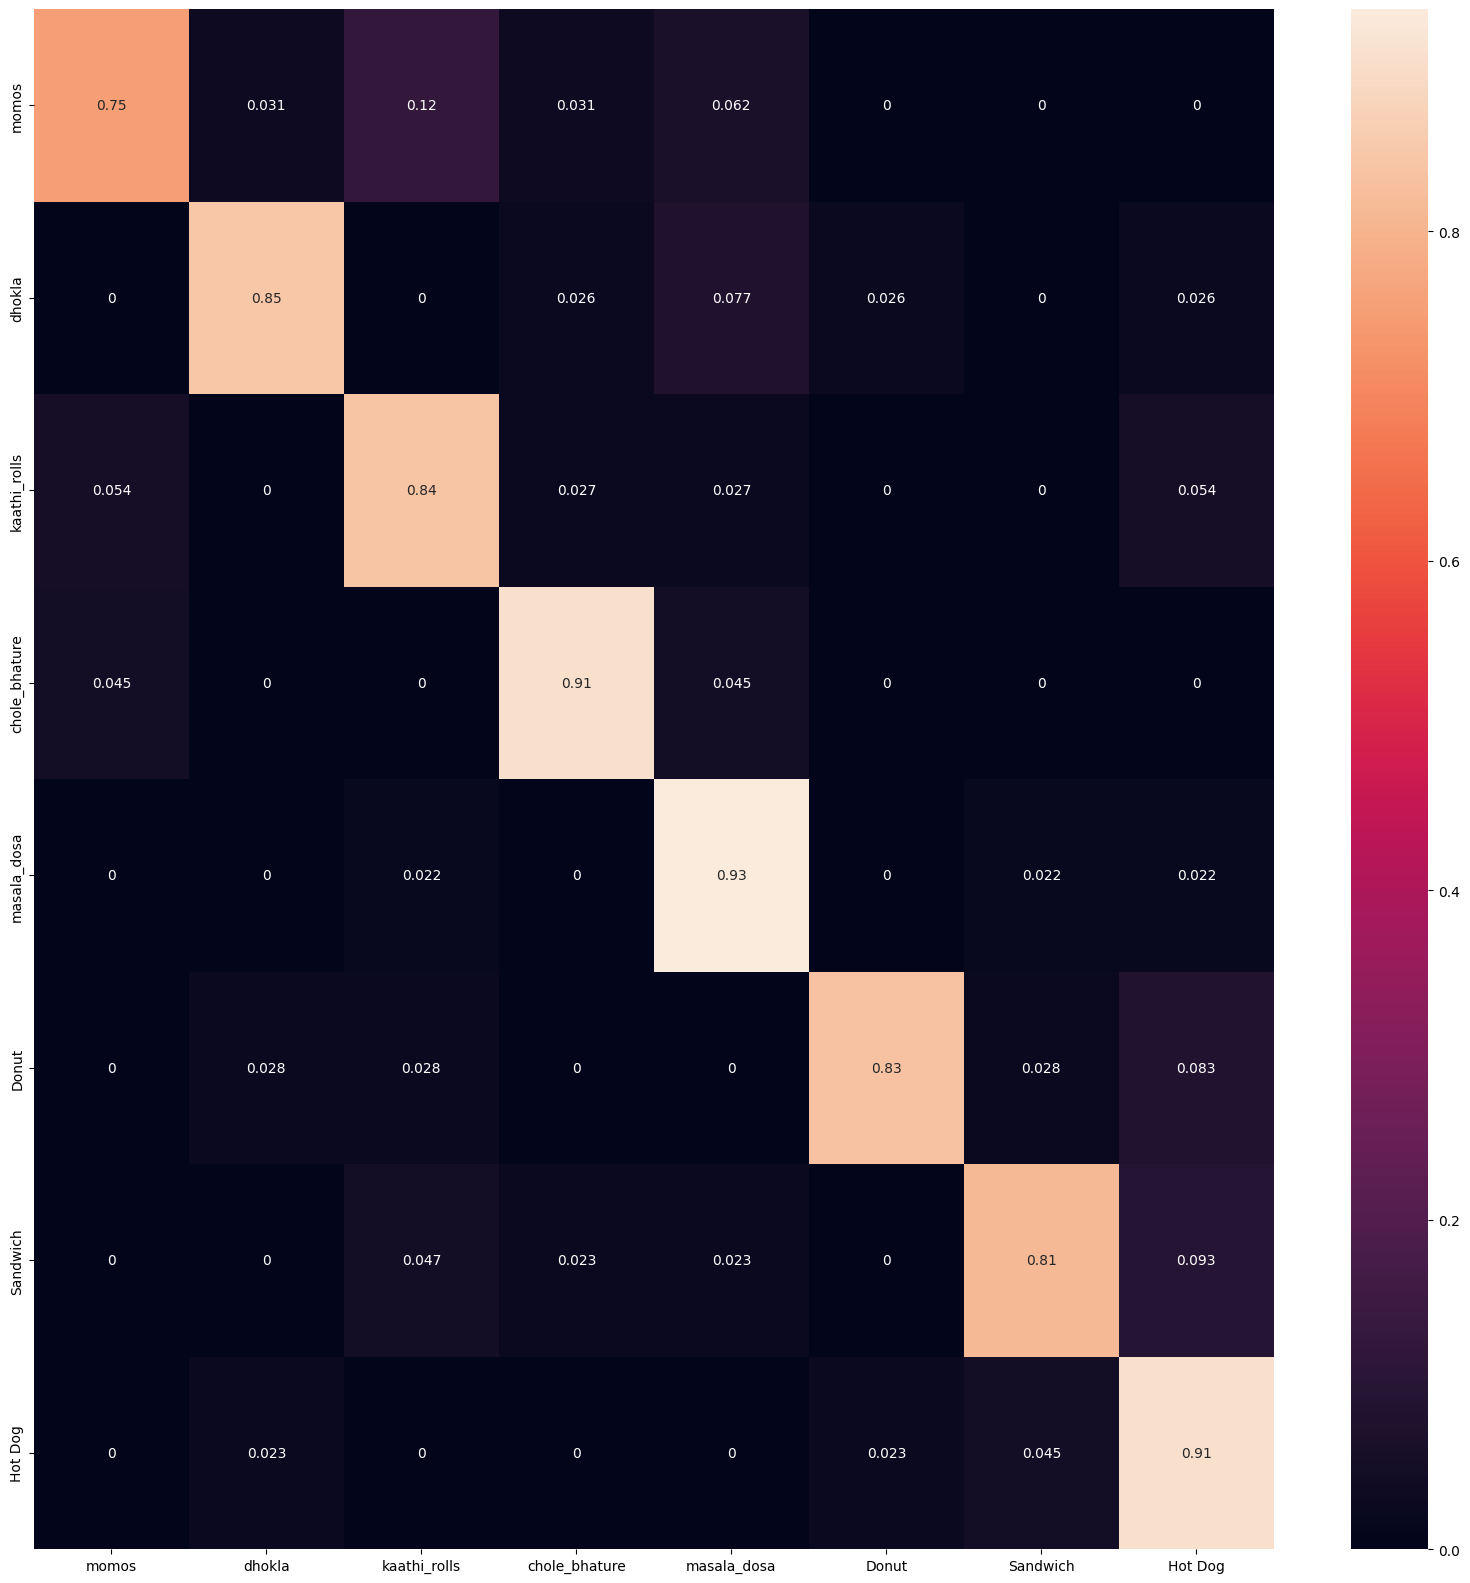

In [67]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in test.dataset.classes[:CLASS_SIZE]],
                     columns = [i for i in test.dataset.classes[:CLASS_SIZE]])
plt.figure(figsize = (20, 20))
sn.heatmap(df_cm, annot=True)
plt.show()

## Part 3.2
**Question**: Evaluate your best model in the test set. Compare your base CNN with the attention-added version.
**Answer**: The primative CNN model did not well trained with 10 epoch, on the other hand, with efficient v2 base power, added attention layer can saparate foods on images.

# Discussion

- For each trial, `10 epochs` was used as a standard.
- The `VerticalFlip` operation was applied while reading the data.
- The `cuda and numpy seeds were fixed` to achieve the same result in each trial.
- Since the CNN model was trained from scratch, the number of epochs determined *indicates that there are not enough epochs*. However, the loss graph shows that this model will improve as the training continues.
- Since the CNN model was not fully trained, *test scores remained relatively low*.
- In EfficientNet, we get the best results when only a Dropout and one linear layer are used. In these experiments, the learning rate was kept constant to compare the layers accurately.
- In EfficientNet, we do not want to train all previous layers except the last layer, so we freeze their weight values. *Therefore, training only takes place on the new layers*.
- Since EfficientNet is a large model, when we compare the model created in Part 1 on the test dataset, *we see that it passes by a large margin*.
- There is little difference between adding and not adding `AttentionBlock` to EfficientNet.


# References
1. https://discuss.pytorch.org/t/attention-in-image-classification/80147/2
2. https://github.com/0aqz0/pytorch-attention-mechanism/blob/master/cnn-with-attention.py
3. https://stackoverflow.com/questions/76648620/how-do-i-implement-this-attention-layer-in-pytorch